In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # Optional for interactive plots
import missingno as msno      # For missing data visualization
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

## EDA

In [2]:
# 2. Load Data
df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
print(f"Data shape: {df.shape}")


Data shape: (750000, 9)


In [3]:
df = pd.concat([df], axis=0, ignore_index=True)
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:

# 3. Basic Info
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,750000.0,NaN,NaN,NaN,374999.5,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Sex,750000,2,female,375721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,750000.0,NaN,NaN,NaN,41.420404,15.175049,20.0,28.0,40.0,52.0,79.0
Height,750000.0,NaN,NaN,NaN,174.697685,12.824496,126.0,164.0,174.0,185.0,222.0
Weight,750000.0,NaN,NaN,NaN,75.145668,13.982704,36.0,63.0,74.0,87.0,132.0
Duration,750000.0,NaN,NaN,NaN,15.421015,8.354095,1.0,8.0,15.0,23.0,30.0
Heart_Rate,750000.0,NaN,NaN,NaN,95.483995,9.449845,67.0,88.0,95.0,103.0,128.0
Body_Temp,750000.0,NaN,NaN,NaN,40.036253,0.779875,37.1,39.6,40.3,40.7,41.5
Calories,750000.0,NaN,NaN,NaN,88.282781,62.395349,1.0,34.0,77.0,136.0,314.0


In [5]:
# 4. Missing Values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})
missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)


,Missing Values,Percent


In [6]:

# 5. Duplicate Rows
print(f"Duplicate rows: {df.duplicated().sum()}")


Duplicate rows: 0


In [7]:

# 6. Data Types & Unique Values
df.dtypes
df.nunique()


id            750000
Sex                2
Age               60
Height            86
Weight            91
Duration          30
Heart_Rate        63
Body_Temp         75
Calories         277
dtype: int64

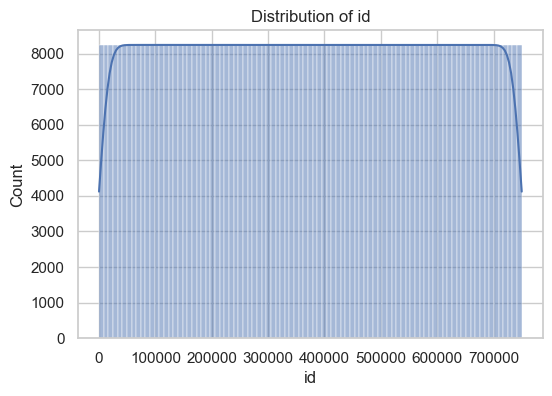

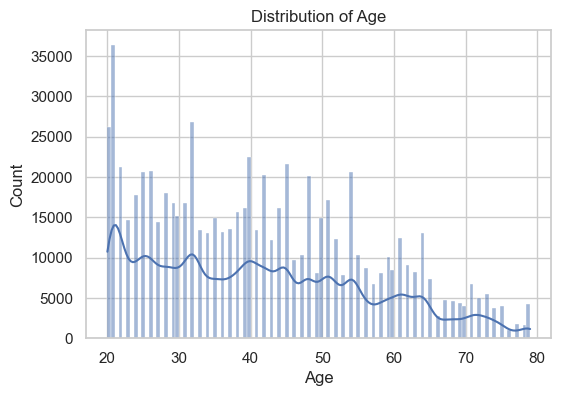

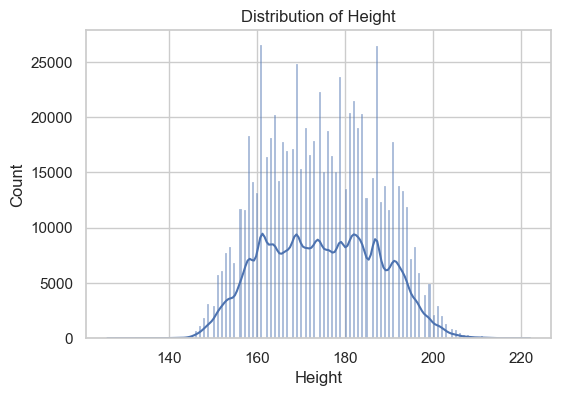

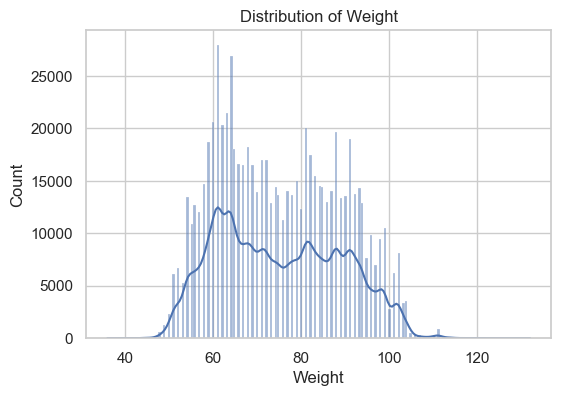

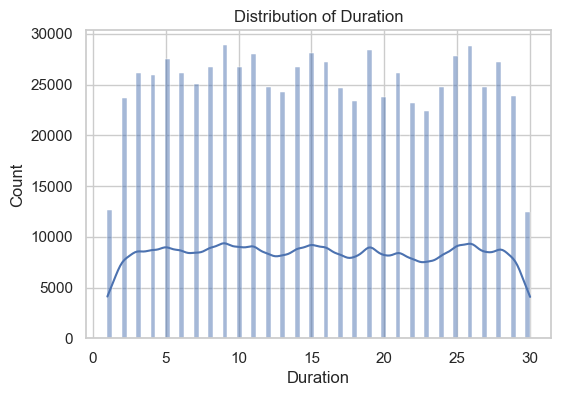

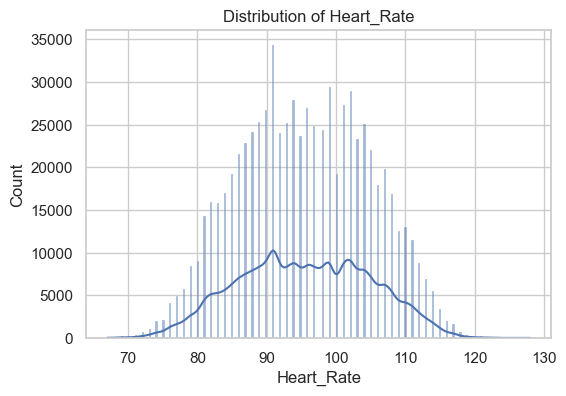

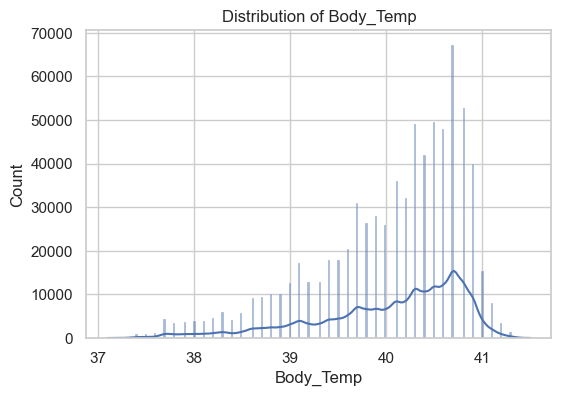

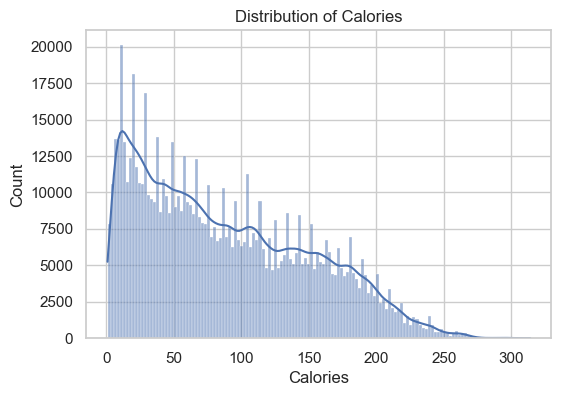

In [8]:
# 7. Univariate Analysis
# Numerical
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


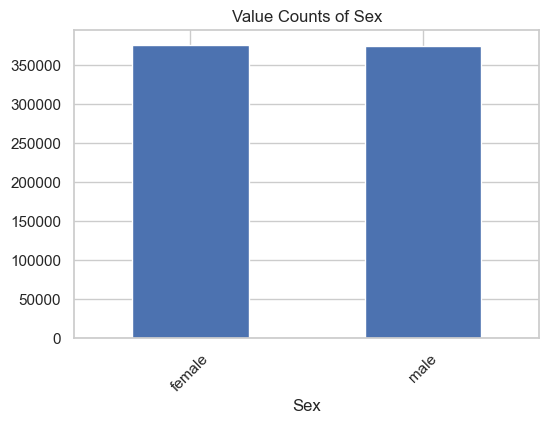

In [9]:

# Categorical
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xticks(rotation=45)
    plt.show()


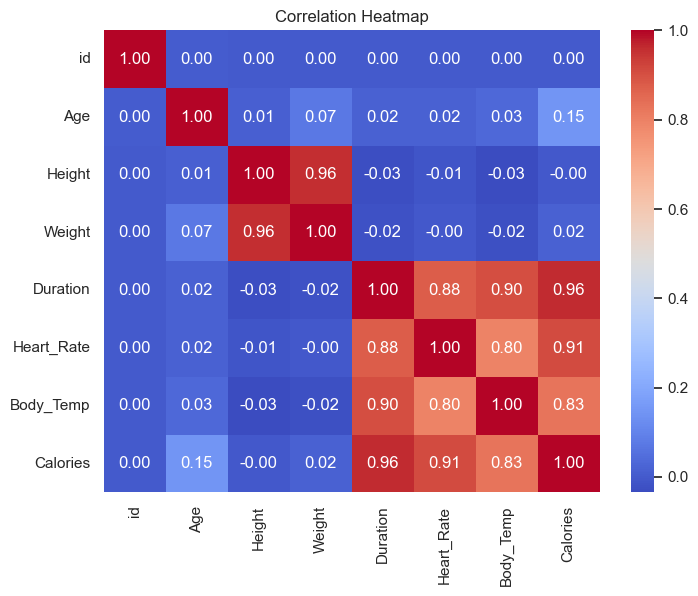

In [10]:

# 8. Bivariate Analysis
# Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


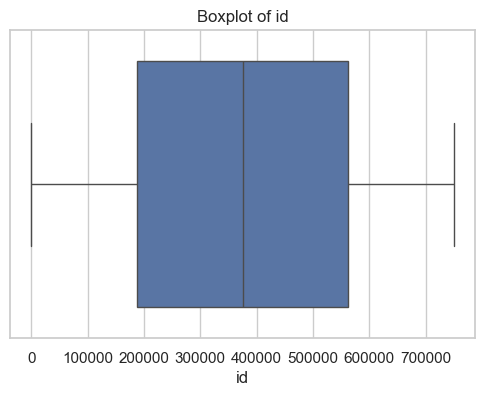

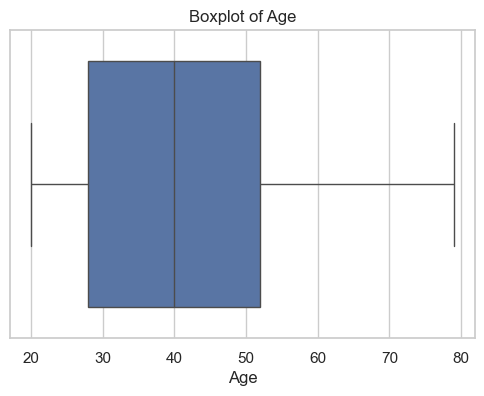

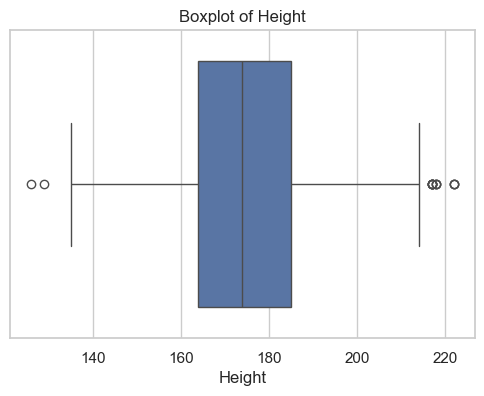

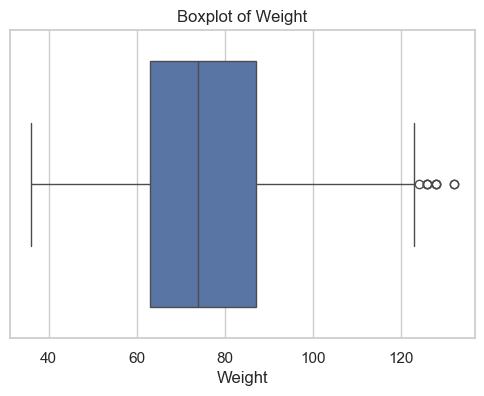

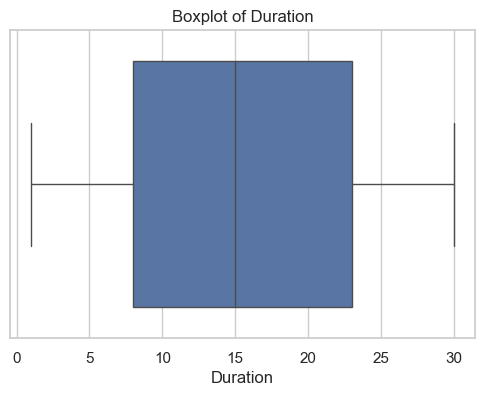

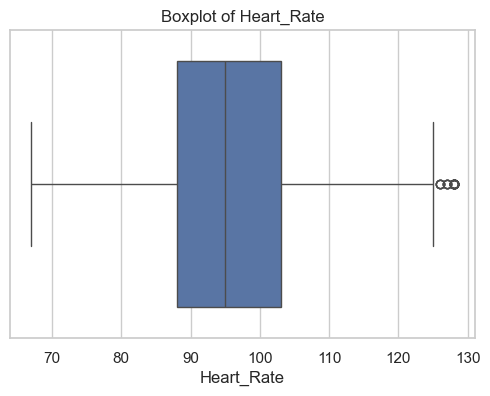

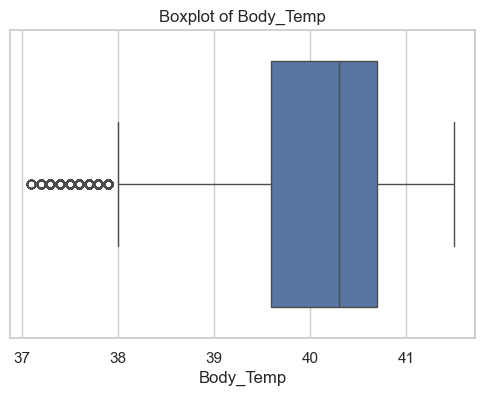

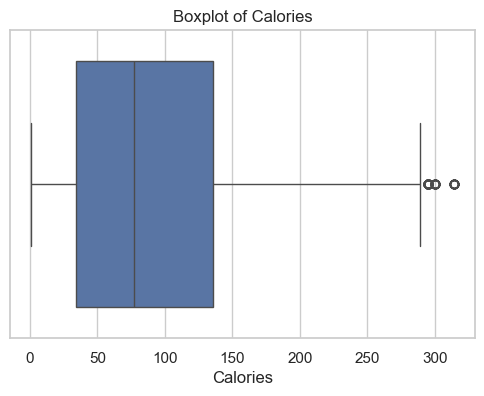

In [11]:

# 9. Outlier Detection
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


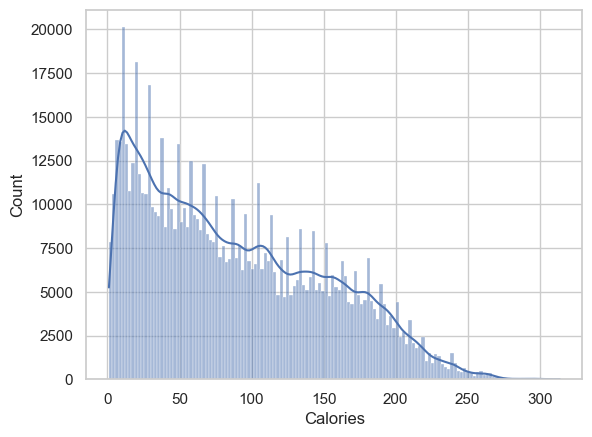

In [12]:

# 11. Target Distribution
target = "Calories"
if target in df.columns:
    if df[target].dtype == 'object':
        df[target].value_counts().plot(kind='bar', title="Target Distribution")
    else:
        sns.histplot(df[target], kde=True)
    plt.show()


## Data Preprocessing

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold

from sklearn.metrics import root_mean_squared_error, r2_score, roc_auc_score, mean_squared_log_error, root_mean_squared_log_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import  xgboost  as _xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from numpy import absolute

In [14]:
# Split train data
X = df.drop(columns=['Calories', 'id'])
Y = df['Calories']

In [15]:
# Get numerical columns automatically
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.difference(cat_cols).tolist()

# Numerical pipeline: impute missing with mean
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

# Categorical pipeline: impute with most frequent, then encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder())
])

# Column transformer: combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, cat_cols)
])

# Final pipeline (can remove classifier if just preprocessing)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
])

# Fit the pipeline
X_encoded = pipeline.fit_transform(X, Y)


In [16]:
# Separate training and testing data
x_train, x_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.3, random_state=42)

#### Model Training

##### XGBRegressor

In [17]:
#Define the model Multivariate Linear Regression
xgb = _xgb.XGBRegressor(device="cuda",
    max_depth=10,
    n_estimators=1000,
    learning_rate=0.015,
    random_state=42)

# Train the model
model = xgb.fit(x_train, y_train)

In [18]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xgb, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.141 (0.011)


In [19]:
#y-intercept of the model
model.intercept_

array([88.32139], dtype=float32)

In [20]:
preds = model.predict(x_test)

In [23]:
root_mean_squared_log_error(y_test, preds)

0.060732545490731184

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

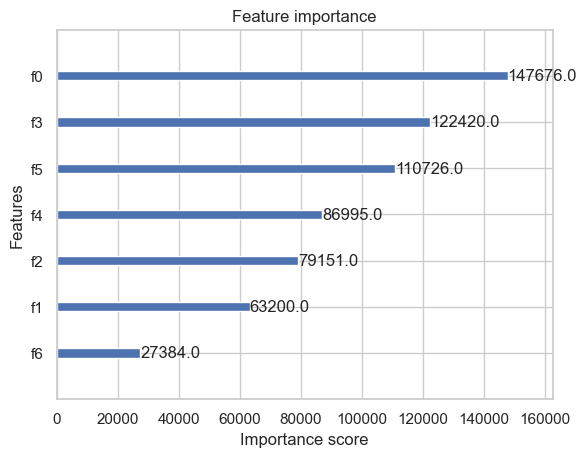

In [24]:
_xgb.plot_importance(model)

##### CatBoostRegressor

In [25]:
#Define the model 
cgb = CatBoostRegressor(loss_function='RMSE',
    max_depth=15,
    n_estimators=4000,
    learning_rate=0.04,
    random_state=42)

# Train the model
model = cgb.fit(x_train, y_train)

0:	learn: 60.0100955	total: 510ms	remaining: 33m 57s
1:	learn: 57.6849894	total: 820ms	remaining: 27m 19s
2:	learn: 55.4499432	total: 1.12s	remaining: 24m 53s
3:	learn: 53.3162652	total: 1.45s	remaining: 24m 11s
4:	learn: 51.2530063	total: 1.73s	remaining: 23m 5s
5:	learn: 49.2751219	total: 2.02s	remaining: 22m 24s
6:	learn: 47.3793426	total: 2.32s	remaining: 22m 5s
7:	learn: 45.5495252	total: 2.64s	remaining: 21m 55s
8:	learn: 43.7994791	total: 2.93s	remaining: 21m 39s
9:	learn: 42.1040931	total: 3.14s	remaining: 20m 54s
10:	learn: 40.4821798	total: 3.44s	remaining: 20m 46s
11:	learn: 38.9191136	total: 3.73s	remaining: 20m 41s
12:	learn: 37.4253193	total: 4.01s	remaining: 20m 30s
13:	learn: 35.9863135	total: 4.31s	remaining: 20m 27s
14:	learn: 34.6003663	total: 4.6s	remaining: 20m 22s
15:	learn: 33.2731232	total: 4.89s	remaining: 20m 17s
16:	learn: 32.0000255	total: 5.18s	remaining: 20m 14s
17:	learn: 30.8015250	total: 5.3s	remaining: 19m 32s
18:	learn: 29.6243920	total: 5.6s	remainin

In [26]:
preds = model.predict(x_test)

In [27]:
root_mean_squared_log_error(y_test, preds)

0.061043627671796136

In [28]:
model.get_feature_importance()

array([15.60408577,  3.99770244, 47.21546408, 25.36153104,  1.01004029,
        1.86031827,  2.61333046,  2.33752765])

##### LGBMRegressor

In [29]:
lgbm = LGBMRegressor(boosting_type='gbdt',
    max_depth=10,
    n_estimators=1000,
    learning_rate=0.3,
    random_state=42) 

lgbm.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 525000, number of used features: 8
[LightGBM] [Info] Start training from score 88.321390


LGBMRegressor(learning_rate=0.3, max_depth=10, n_estimators=1000,
              random_state=42)

In [30]:
lgbm.score(x_test, y_test)

0.9964400677873129

In [31]:
preds = lgbm.predict(x_test)

In [32]:
root_mean_squared_log_error(y_test, preds)

0.0635568922317788

The best perfoming model based on the selected Metric is `XGBoost`